In [12]:
import os
import googleapiclient.discovery
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = "[Your Developer Key]"

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey = DEVELOPER_KEY
)


In [14]:
print(np.__version__,pd.__version__,matplotlib.__version__, sns.__version__)

1.18.5 1.0.5 3.2.2 0.11.1


In [45]:
def video_scraper(search_word: str, region_code: str, page_num: int):
    """ Scrapes information about each video.
    
    :param 1 search_word: A search keyword on YouTube
    :param 2 region_code: A country code for searching
    :param 3 page_num: Number of page results - recommend 5 to 10 pages, since there is a restriction due to cost limits
    
    :return: Multiple lists of information of the video  
    """
    
    video_id_list = []
    published_dt_list = []
    title_list = []
    channel_title_list = []

    # First search page scraping
    search_request = youtube.search().list(
            q=search_word,
            order="relevance",
            part="snippet",
            maxResults=50,
            regionCode=region_code,
            publishedAfter="2021-02-01T00:00:00Z",
            publishedBefore="2021-04-07T00:00:00Z"

    )
    
    response_ = search_request.execute()
    next_page_token = response_['nextPageToken']
    response = [i for i in response_['items'] if 'videoId' in i['id']]
    
    # Append each video infor to the respective list
    video_id_list += [i['id']['videoId'] for i in response]
    published_dt_list += [i['snippet']['publishedAt'] for i in response]
    title_list += [i['snippet']['title'] for i in response]
    channel_title_list += [i['snippet']['channelTitle'] for i in response]

    # Scrape next pages 
    for i in range(page_num - 1):
        search_request = youtube.search().list(
            q=search_word,
            order="relevance",
            pageToken=next_page_token,
            part="snippet",
            maxResults=50,
            regionCode=region_code,
            publishedAfter="2021-02-01T00:00:00Z",
            publishedBefore="2021-04-07T00:00:00Z"
        )
        response_ = search_request.execute()
        
        response = [i for i in response_['items'] if 'videoId' in i['id']]
    
        video_id_list += [i['id']['videoId'] for i in response]
        published_dt_list += [i['snippet']['publishedAt'] for i in response]
        title_list += [i['snippet']['title'] for i in response]
        channel_title_list += [i['snippet']['channelTitle'] for i in response]

        if 'nextPageToken' in response_:
            next_page_token = response_['nextPageToken']
        else:
            break
        
    # Retrieve statistical info (views, likes, dislikes, comment counts)
    statistics = []

    for i in video_id_list:
        request = youtube.videos().list(
            part="statistics",
            id=i
        )
        response = request.execute()
        res = response['items'][0]['statistics']
        statistics.append(res)
    
    views = []
    likes = []
    dislikes = []
    comments = []

    for i in statistics:
        if "viewCount" in i:
            views.append(i['viewCount'])
        else:
            views.append(None)
        if "likeCount" in i:
            likes.append(i['likeCount'])    
        else:
            likes.append(None)
        if "dislikeCount" in i:
            dislikes.append(i['dislikeCount'])    
        else:
            dislikes.append(None)
        if "commentCount" in i:
            comments.append(i['commentCount'])
        else:
            comments.append(None)
    
    return video_id_list, published_dt_list, title_list, channel_title_list, views, likes, dislikes, comments

In [63]:
def make_df(search_word: str, region_code: str, page_num: int):
    """ Creates DataFrame object based on the search
    
    :param 1 search_word: A search keyword on YouTube
    :param 2 region_code: A country code for searching
    :param 3 page_num: Number of page results - recommend 5 to 10 pages, since there is a restriction due to cost limits
    
    :return: DataFrame  
    """
    
    video_id_list, published_dt_list, title_list, channel_title_list,views,likes,dislikes,comments = video_scraper(search_word, region_code, page_num)
    
    # Make dataframe consisting of each column
    df = pd.DataFrame(np.array([video_id_list, published_dt_list, title_list, channel_title_list,views,likes,dislikes,comments]).T, 
                        columns=["video_id","published_dt",'title','channel_title','views','likes','dislikes','comments'])

    # Remove None 
    df.fillna(value=np.nan, inplace=True)

    # Add like/dislike ratio
    df.loc[~df['likes'].isnull() & ~df['dislikes'].isnull(), 'like/dislike ratio'] = df.loc[~df['likes'].isnull(),'likes'].astype('int64')/ (df.loc[~df['likes'].isnull(),'likes'].astype('int64') + df.loc[~df['dislikes'].isnull(),'dislikes'].astype('int64'))
    
    # Add like per view
    df.loc[~df['likes'].isnull() & ~df['views'].isnull(), 'likes per view'] = df.loc[~df['likes'].isnull(),'likes'].astype('int64')/ df.loc[~df['views'].isnull(),'views'].astype('int64')
    
    # Show number of missing values for each column
    print("Number of missing values in each column")
    print(df.isnull().sum())
    print("\n")
    
    # Change dtype into Int64
    df['views'] = df['views'].astype('float').astype('Int64')
    df['likes'] = df['likes'].astype('float').astype('Int64')
    df['dislikes'] = df['dislikes'].astype('float').astype('Int64') 
    df['comments'] = df['comments'].astype('float').astype('Int64')   
        
    return df    

In [64]:
# Create dataframe with names of each candidate - we used 6 for arbitrary page numbers 
oh_df = make_df("오세훈", "KR", 6)
park_df = make_df("박영선", "KR", 6)

Number of missing values in each column
video_id              0
published_dt          0
title                 0
channel_title         0
views                 0
likes                 6
dislikes              6
comments              0
like/dislike ratio    6
likes per view        6
dtype: int64


Number of missing values in each column
video_id               0
published_dt           0
title                  0
channel_title          0
views                  0
likes                 21
dislikes              21
comments               5
like/dislike ratio    21
likes per view        21
dtype: int64




In [65]:
display(oh_df, park_df) # Display dataframes

,video_id,published_dt,title,channel_title,views,likes,dislikes,comments,like/dislike ratio,likes per view
0,UlsJSxFG-WQ,2021-04-05T06:09:22Z,"박영선·오세훈, 서울시장 선거 마지막 TV토론 ① / YTN",YTN news,230207,1919,218,2241,0.897988,0.008336
1,W_2txakw094,2021-03-19T05:16:34Z,"오세훈, 야권 단일화 관련 긴급 기자회견 / YTN",YTN news,15407,231,43,226,0.843066,0.014993
2,kPdeR7Bn_8k,2021-03-30T15:33:20Z,"[풀영상] 2021 서울시장 보궐선거 후보자 토론회 (박영선, 오세훈, 이수봉 후보...",KBS News,438007,3765,587,4739,0.865119,0.008596
3,N93RW2mgWxw,2021-04-02T09:15:01Z,"[100분토론] 박영선VS오세훈 주도권토론, 승자는? | 정준희 | 박영선 | 오세훈",MBC 100분토론,759907,5001,237,6577,0.954754,0.006581
4,MoqXSng4CO4,2021-03-16T11:09:13Z,[다시보기] 오세훈-안철수 서울시장 후보 단일화 토론 / SBS,SBS 뉴스,646017,9616,849,2373,0.918872,0.014885
...,...,...,...,...,...,...,...,...,...,...
294,TfciQX_DaaU,2021-04-03T05:22:50Z,"오세훈후보 고척스카이돔 배현진, 이준석",선데이타임즈(옥탑방TV),2594,207,5,3,0.976415,0.079800
295,IUmH_kQa3p0,2021-04-06T07:47:11Z,오세훈서울시장후보4/6-1,우파삼촌tv,4206,575,31,0,0.948845,0.136709
296,fte-NrtnYq0,2021-03-31T12:04:02Z,오세훈서울시장후보유세 3/31,우파삼촌tv,5596,825,33,7,0.961538,0.147427
297,Cc-doYBEifA,2021-04-03T02:44:13Z,오세훈 후보 사퇴 안 하는 이유를 물어봤습니다,황기자,13641,1195,29,310,0.976307,0.087604


,video_id,published_dt,title,channel_title,views,likes,dislikes,comments,like/dislike ratio,likes per view
0,UlsJSxFG-WQ,2021-04-05T06:09:22Z,"박영선·오세훈, 서울시장 선거 마지막 TV토론 ① / YTN",YTN news,230209,1919,218,2241,0.897988,0.008336
1,YzjzN8jON1Q,2021-03-30T14:00:08Z,"박영선-오세훈 첫 토론회, 평가는? / SBS / 주영진의 HOT 브리핑",SBS 뉴스,77362,696,68,1388,0.910995,0.008997
2,WY1hzVAPP8U,2021-03-31T02:02:53Z,통번역 학생에게 AI번역 추천한 박영선 | 김진의 돌직구 쇼 707 회,채널A 김진의 돌직구쇼,83279,1044,29,830,0.972973,0.012536
3,GNUavkzBr2w,2021-03-12T10:53:36Z,[박영선·김진애 서울시장 후보 단일화 토론회] 특집 정치부회의 풀영상 (2021.0...,JTBC News,280364,6240,491,2808,0.927054,0.022257
4,qqZLvChtpko,2021-04-04T12:41:26Z,[비하인드+] &quot;사전투표에서 우세&quot; 박영선 도우려다 거센 후폭풍 ...,JTBC News,41076,324,46,208,0.875676,0.007888
...,...,...,...,...,...,...,...,...,...,...
295,-vHkeRjNGTM,2021-03-17T05:08:57Z,"야권, 단일화 담판 날까지 대치...박영선 &#39;서울시 재난지원금&#39; 보류...",YTN news,2197,25,2,12,0.925926,0.011379
296,D0ud567YgFY,2021-04-06T04:55:34Z,"서울은 역시 박영선, 이낙연 선대위원장 서울 강동구 길동 강동우체국 앞 현장유세 라이브",이낙연TV,8319,1206,72,68,0.943662,0.144969
297,YICug0NI-Aw,2021-03-24T00:07:33Z,"오세훈, 野 단일후보 확정...박영선과 양자대결(이택수,박시영,윤희웅)/서울 아파트...",TBS 시민의방송,217824,7851,378,716,0.954065,0.036043
298,sU4X0qDcPpM,2021-03-15T11:20:32Z,박영선·김진애 서울시장후보 단일화 토론회 생중계,델리민주 Daily Minjoo,5336,659,11,66,0.983582,0.123501


[Text(0, 0.5, 'Video Count')]

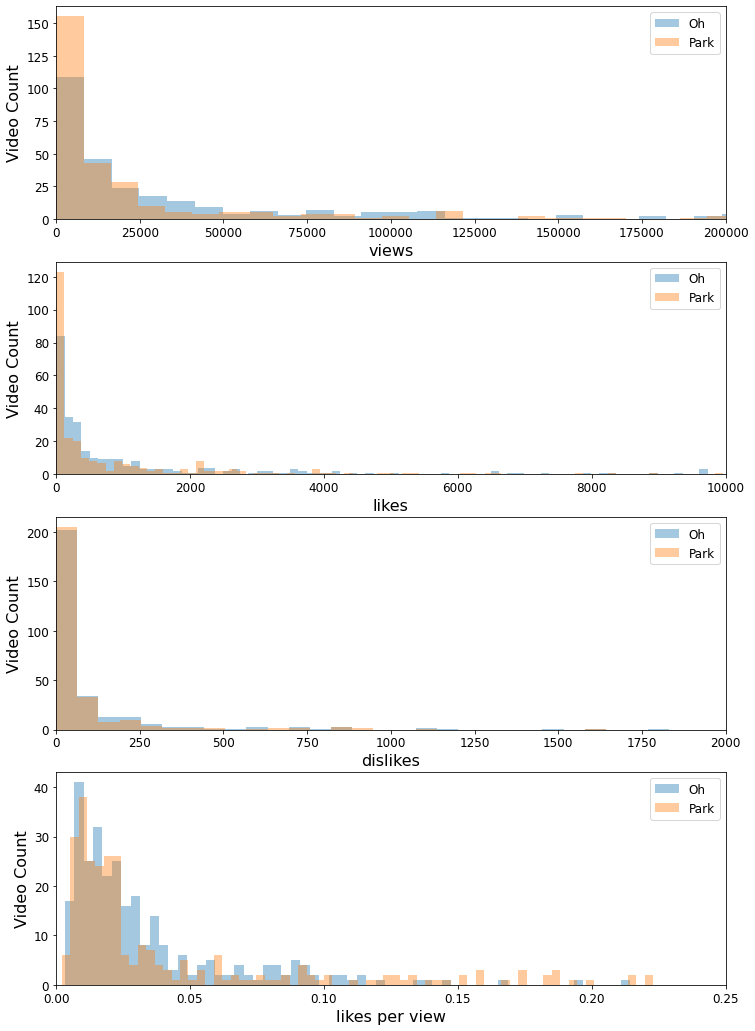

In [69]:
plt.rcParams['figure.figsize'] = (12,18)
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12

f, axes = plt.subplots(4, 1)

axes[0].set_xlim(0,200000)
axes[1].set_xlim(0,10000)
axes[2].set_xlim(0,2000)
axes[3].set_xlim(0,0.25)

sns.distplot(oh_df.loc[~oh_df['views'].isnull(), 'views'], bins=200, ax=axes[0], kde=False, label="Oh")
sns.distplot(park_df.loc[~park_df['views'].isnull(), 'views'], bins=200, ax=axes[0], kde=False, label="Park")
axes[0].legend()
axes[0].set(ylabel="Video Count")

sns.distplot(oh_df.loc[~oh_df['likes'].isnull(), 'likes'], bins=500, ax=axes[1], kde=False, label="Oh")
sns.distplot(park_df.loc[~park_df['likes'].isnull(), 'likes'], bins=500, ax=axes[1], kde=False, label="Park")
axes[1].legend()
axes[1].set(ylabel="Video Count")

sns.distplot(oh_df.loc[~oh_df['dislikes'].isnull(), 'dislikes'], bins=50, ax=axes[2], kde=False, label="Oh")
sns.distplot(park_df.loc[~park_df['dislikes'].isnull(), 'dislikes'], bins=50, ax=axes[2], kde=False, label="Park")
axes[2].legend()
axes[2].set(ylabel="Video Count")

sns.distplot(oh_df.loc[~oh_df['likes per view'].isnull(), 'likes per view'], bins=100, ax=axes[3], kde=False, label="Oh")
sns.distplot(park_df.loc[~park_df['likes per view'].isnull(), 'likes per view'], bins=100, ax=axes[3], kde=False, label="Park")
axes[3].legend()
axes[3].set(ylabel="Video Count")


#axs[1].hist(y, bins=n_bins)

(0.0, 20000.0)

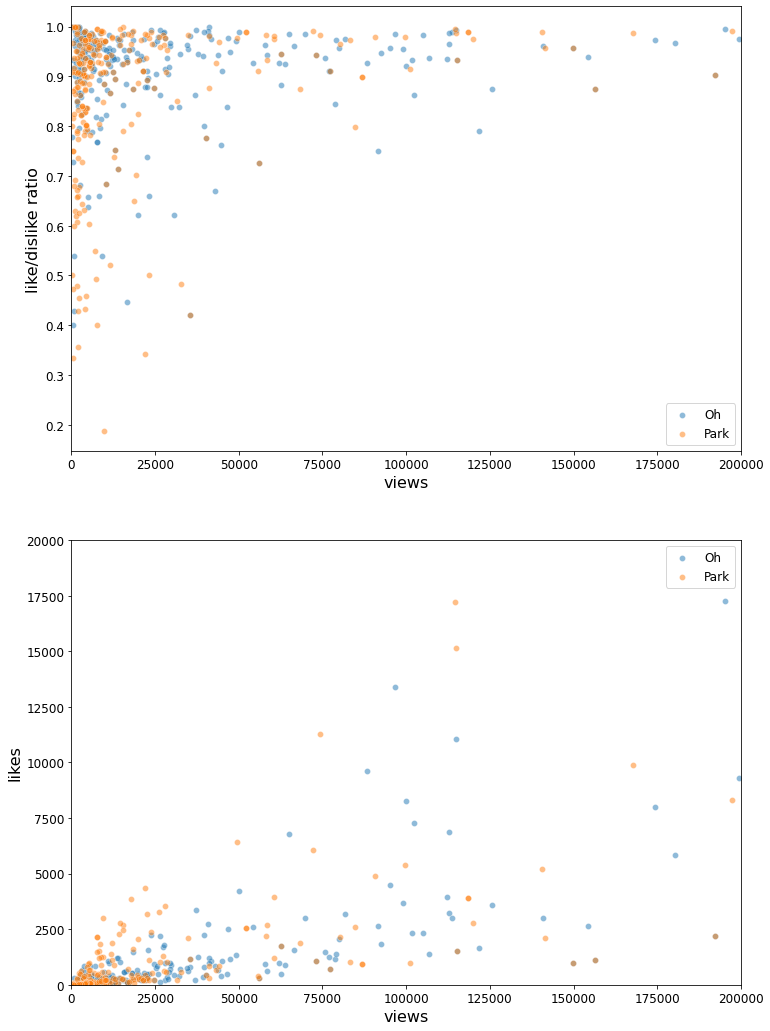

In [70]:
plt.rcParams['figure.figsize'] = (12,18)

fig, axes = plt.subplots(2,1)
sns.scatterplot(data=oh_df, ax=axes[0], x='views', y='like/dislike ratio', alpha=0.5, label="Oh")
sns.scatterplot(data=park_df, ax=axes[0], x='views', y='like/dislike ratio', alpha=0.5, label="Park")

sns.scatterplot(data=oh_df, ax=axes[1], x='views', y='likes', alpha=0.5, label="Oh")
sns.scatterplot(data=park_df, ax=axes[1], x='views', y='likes', alpha=0.5, label="Park")

axes[0].set_xlim(0,200000)
axes[1].set_xlim(0,200000)
axes[1].set_ylim(0,20000)

,views,likes,dislikes,comments,like/dislike ratio,likes per view
count,2.990000e+02,293.000000,293.000000,299.000000,293.000000,293.000000
mean,7.537261e+04,2094.160410,119.392491,570.364548,0.910676,0.034379
std,1.827874e+05,5409.870205,299.662698,1415.276596,0.099430,0.037552
min,4.300000e+01,2.000000,0.000000,0.000000,0.400000,0.003221
25%,4.419500e+03,111.000000,7.000000,45.000000,0.896552,0.012115
50%,1.572900e+04,353.000000,24.000000,144.000000,0.939628,0.021935
75%,5.810350e+04,1481.000000,94.000000,433.000000,0.968894,0.038967
max,1.657087e+06,62384.000000,3158.000000,13092.000000,1.000000,0.355072


,views,likes,dislikes,comments,like/dislike ratio,likes per view
count,3.000000e+02,279.000000,279.000000,295.000000,279.000000,279.000000
mean,5.464407e+04,1920.985663,96.318996,396.986441,0.872747,0.043832
std,1.743459e+05,6276.346704,267.012291,1124.150748,0.148292,0.056185
min,1.100000e+02,1.000000,0.000000,0.000000,0.187919,0.002088
25%,3.310250e+03,50.500000,6.000000,31.000000,0.836093,0.011382
50%,7.682500e+03,206.000000,17.000000,88.000000,0.927054,0.019860
75%,2.377400e+04,1186.000000,66.000000,307.500000,0.972598,0.046760
max,1.620343e+06,61518.000000,3158.000000,11304.000000,1.000000,0.317692


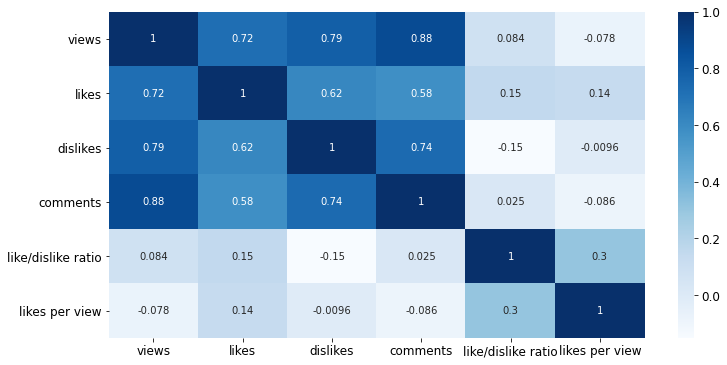

In [66]:
display(oh_df.describe())
display(park_df.describe())

# Show simple correlation among columns
plt.figure(figsize=(12, 6))
sns.heatmap(oh_df.dropna().corr(), annot=True, cmap="Blues")